In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')


# Data Understanding & Initial EDA

In [2]:
# Settings for nicer plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)

In [3]:
# 1. Load Dataset
data = pd.read_csv("Fraud_Analysis_Dataset.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


In [4]:
# Dataset shape (rows, columns)
print("\nShape of dataset:", data.shape)

# Data types and info
print("\n--- Data Info ---")
print(data.info())

# Check for missing values
print("\n--- Missing Values ---")
print(data.isnull().sum())


Shape of dataset: (11142, 10)

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            11142 non-null  int64  
 1   type            11142 non-null  object 
 2   amount          11142 non-null  float64
 3   nameOrig        11142 non-null  object 
 4   oldbalanceOrg   11142 non-null  float64
 5   newbalanceOrig  11142 non-null  float64
 6   nameDest        11142 non-null  object 
 7   oldbalanceDest  11142 non-null  float64
 8   newbalanceDest  11142 non-null  float64
 9   isFraud         11142 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 870.6+ KB
None

--- Missing Values ---
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: i

### Target Distribution (Fraud vs Non-Fraud)

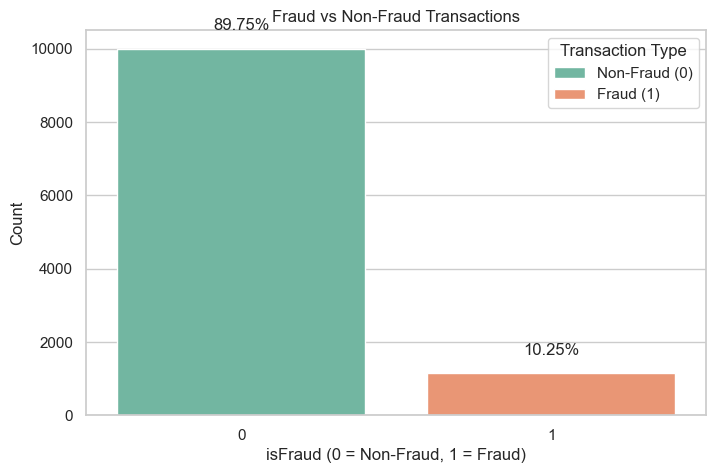


Fraud Distribution:
          Count  Percentage
isFraud                   
0        10000       89.75
1         1142       10.25


In [5]:
fraud_counts = data['isFraud'].value_counts()
fraud_percent = fraud_counts / len(data) * 100

# Labels for legend
labels = ["Non-Fraud (0)", "Fraud (1)"]

plt.figure()
bars = sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="Set2")

plt.title("Fraud vs Non-Fraud Transactions")
plt.ylabel("Count")
plt.xlabel("isFraud (0 = Non-Fraud, 1 = Fraud)")

# Add percentage text on top of bars
for i, v in enumerate(fraud_counts.values):
    plt.text(i, v + 500, f"{fraud_percent[i]:.2f}%", ha='center')

# Add legend mapping colors to labels
for patch, label in zip(bars.patches, labels):
    patch.set_label(label)
plt.legend(title="Transaction Type")

plt.show()

print("\nFraud Distribution:\n", pd.DataFrame({
    "Count": fraud_counts,
    "Percentage": fraud_percent.round(2)
}))


### Transaction Type Distribution

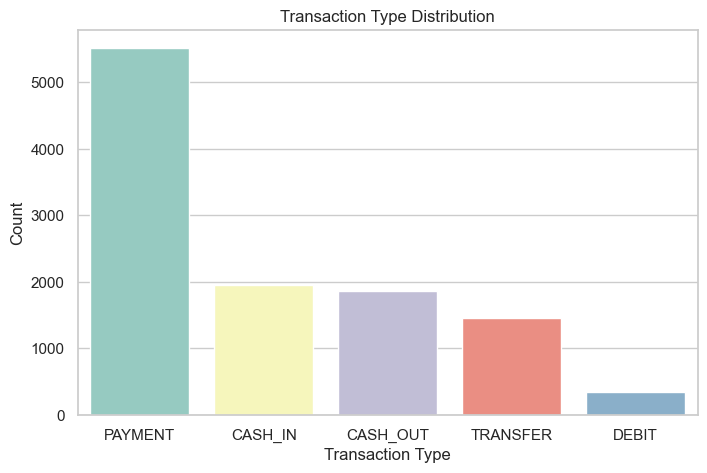

In [6]:
plt.figure()
sns.countplot(data=data, x='type', order=data['type'].value_counts().index, palette="Set3")
plt.title("Transaction Type Distribution")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()


### Amount Distribution (Overall & by Fraud Status)

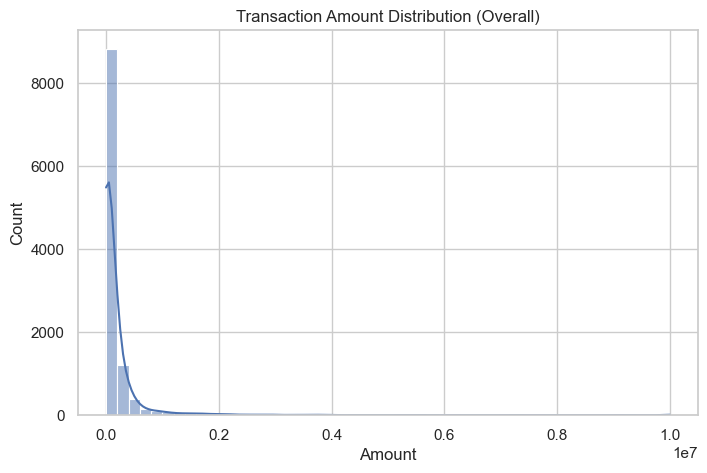

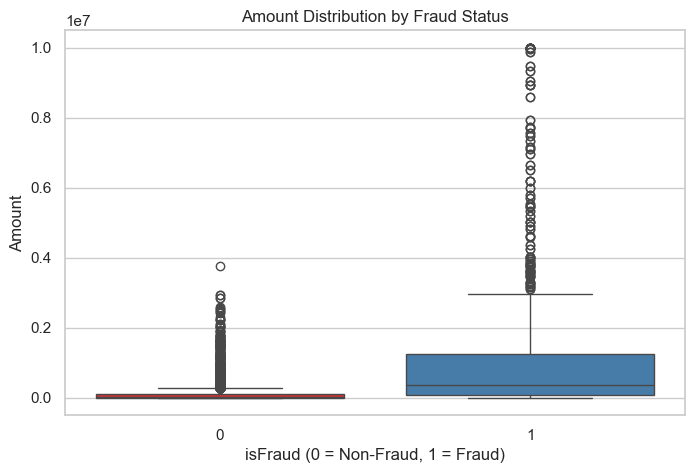

In [7]:
plt.figure()
sns.histplot(data['amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution (Overall)")
plt.xlabel("Amount")
plt.show()

plt.figure()
sns.boxplot(data=data, x='isFraud', y='amount', palette="Set1")
plt.title("Amount Distribution by Fraud Status")
plt.xlabel("isFraud (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Amount")
plt.show()

### Fraud Frequency by Transaction Type


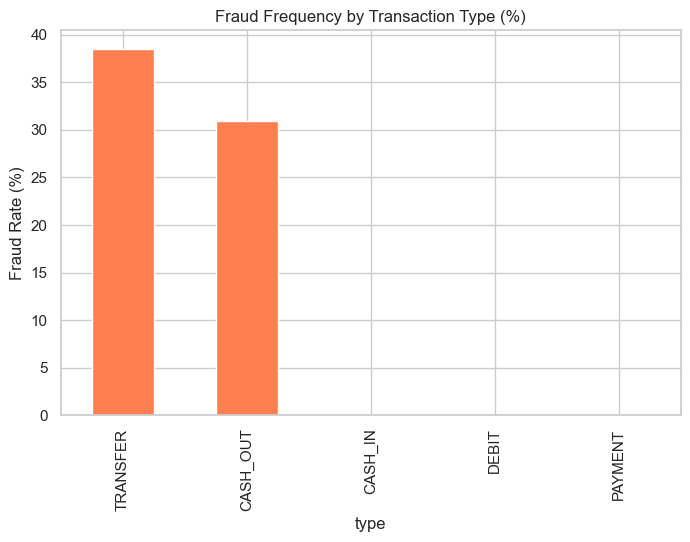


Fraud Rate by Transaction Type (%):
 type
CASH_IN      0.00
CASH_OUT    30.89
DEBIT        0.00
PAYMENT      0.00
TRANSFER    38.52
Name: isFraud, dtype: float64


In [8]:
fraud_by_type = data.groupby('type')['isFraud'].mean() * 100

plt.figure()
fraud_by_type.sort_values(ascending=False).plot(kind='bar', color='coral')
plt.title("Fraud Frequency by Transaction Type (%)")
plt.ylabel("Fraud Rate (%)")
plt.show()

print("\nFraud Rate by Transaction Type (%):\n", fraud_by_type.round(2))

### Time Trend of Fraud Cases 

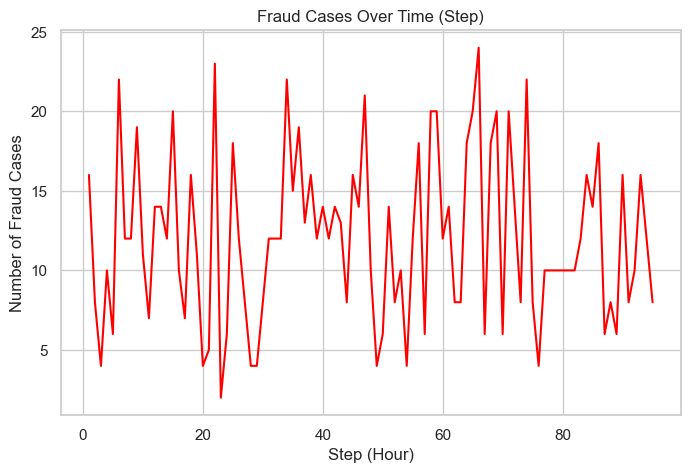

In [9]:
fraud_by_step = data.groupby('step')['isFraud'].sum()

plt.figure()
fraud_by_step.plot(color='red')
plt.title("Fraud Cases Over Time (Step)")
plt.xlabel("Step (Hour)")
plt.ylabel("Number of Fraud Cases")
plt.show()

In [10]:
# observation 
observations = f"""
Observations:
1. The dataset contains {data.shape[0]} rows and {data.shape[1]} columns.
2. Fraud cases make up {fraud_percent[1]:.2f}% of all transactions, indicating a highly imbalanced dataset.
3. Most transactions are of type '{data['type'].value_counts().idxmax()}', 
   while '{fraud_by_type.idxmax()}' has the highest fraud percentage.
4. Fraudulent transactions often involve higher transaction amounts compared to non-fraudulent ones.
5. Fraud activity appears to spike during certain time steps, suggesting potential temporal patterns.
"""
print(observations)


Observations:
1. The dataset contains 11142 rows and 10 columns.
2. Fraud cases make up 10.25% of all transactions, indicating a highly imbalanced dataset.
3. Most transactions are of type 'PAYMENT', 
   while 'TRANSFER' has the highest fraud percentage.
4. Fraudulent transactions often involve higher transaction amounts compared to non-fraudulent ones.
5. Fraud activity appears to spike during certain time steps, suggesting potential temporal patterns.



 **Initial EDA**
   - Loaded dataset, checked structure & missing values.
   - Analyzed fraud vs non-fraud distribution.
   - Visualized transaction types, amounts, and fraud frequency by type.
   - Observed fraud patterns over time (`step`).

# SOME DEEP EDA

In [11]:
# we do a data backup from here first
df= data.copy()
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


### Fraud distribution within each transaction type

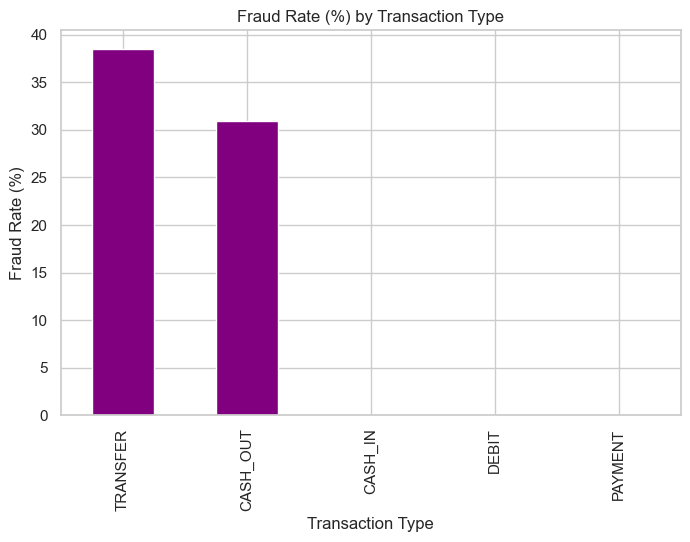


Fraud Rate by Transaction Type (%):
 type
CASH_IN      0.00
CASH_OUT    30.89
DEBIT        0.00
PAYMENT      0.00
TRANSFER    38.52
Name: isFraud, dtype: float64


In [12]:
fraud_dist_type = df.groupby('type')['isFraud'].mean() * 100

plt.figure()
fraud_dist_type.sort_values(ascending=False).plot(kind='bar', color='purple')
plt.title("Fraud Rate (%) by Transaction Type")
plt.ylabel("Fraud Rate (%)")
plt.xlabel("Transaction Type")
plt.show()

print("\nFraud Rate by Transaction Type (%):\n", fraud_dist_type.round(2))

### Fraud by transaction amount buckets

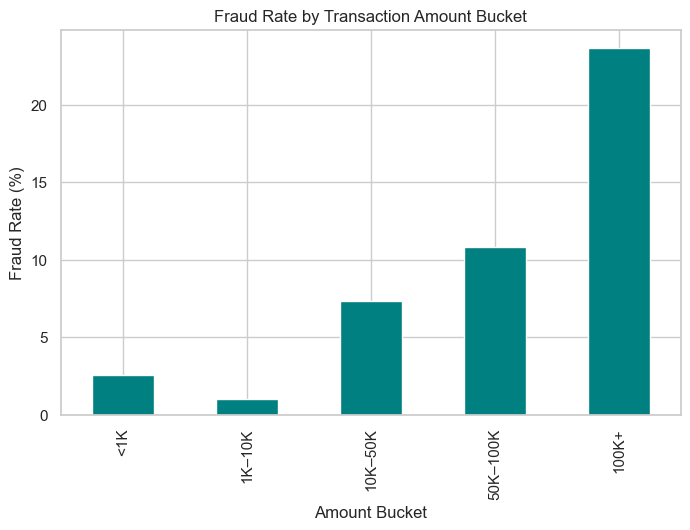


Fraud Rate by Amount Bucket (%):
 amount_bucket
<1K          2.56
1K–10K       1.02
10K–50K      7.33
50K–100K    10.83
100K+       23.64
Name: isFraud, dtype: float64


In [13]:
# Define buckets
bins = [0, 1000, 10000, 50000, 100000, df['amount'].max()]
labels = ['<1K', '1K–10K', '10K–50K', '50K–100K', '100K+']
df['amount_bucket'] = pd.cut(df['amount'], bins=bins, labels=labels)

fraud_by_bucket = df.groupby('amount_bucket')['isFraud'].mean() * 100

plt.figure()
fraud_by_bucket.plot(kind='bar', color='teal')
plt.title("Fraud Rate by Transaction Amount Bucket")
plt.ylabel("Fraud Rate (%)")
plt.xlabel("Amount Bucket")
plt.show()

print("\nFraud Rate by Amount Bucket (%):\n", fraud_by_bucket.round(2))

### Time trends – fraud cases by step (and by type)

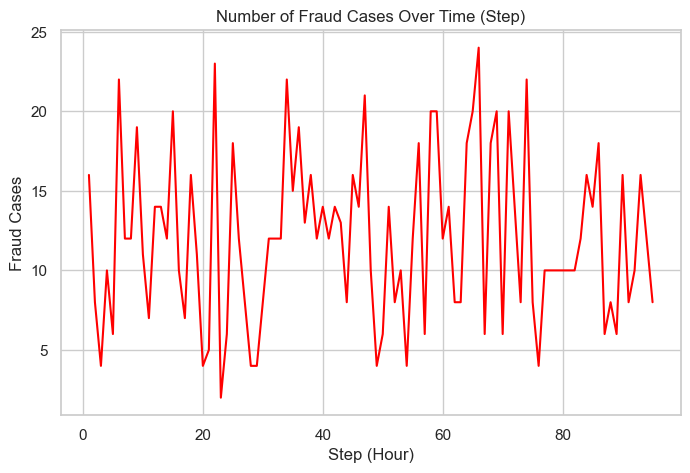

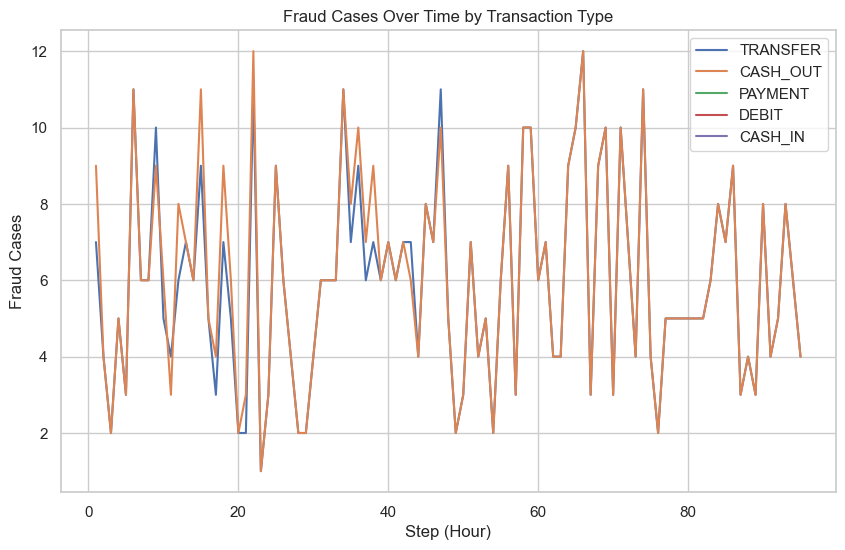

In [14]:
# Fraud cases by step overall
fraud_step = df[df['isFraud'] == 1].groupby('step').size()

plt.figure()
fraud_step.plot(color='red')
plt.title("Number of Fraud Cases Over Time (Step)")
plt.xlabel("Step (Hour)")
plt.ylabel("Fraud Cases")
plt.show()

# Fraud cases by step for each type
plt.figure(figsize=(10,6))
for t_type in df['type'].unique():
    fraud_step_type = df[(df['isFraud'] == 1) & (df['type'] == t_type)].groupby('step').size()
    plt.plot(fraud_step_type.index, fraud_step_type.values, label=t_type)
plt.title("Fraud Cases Over Time by Transaction Type")
plt.xlabel("Step (Hour)")
plt.ylabel("Fraud Cases")
plt.legend()
plt.show()


### Explore account balances before/after transactions

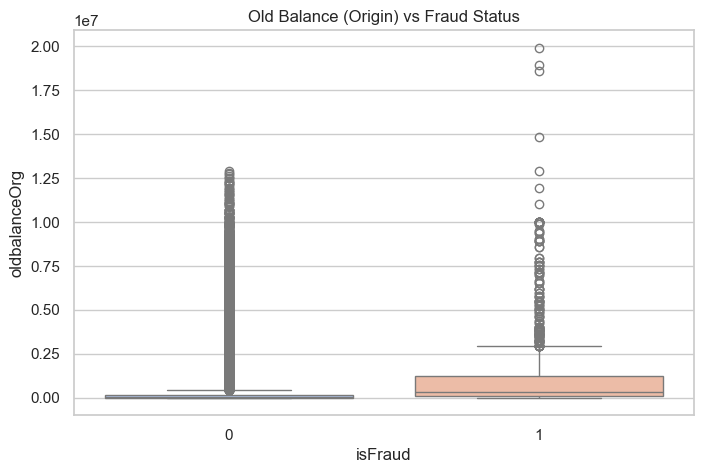

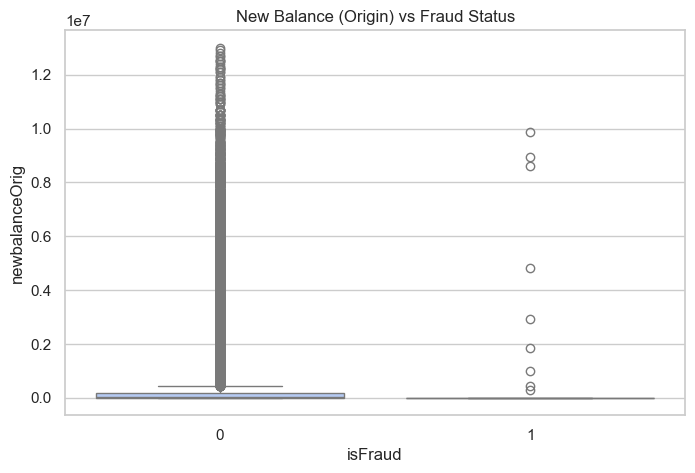

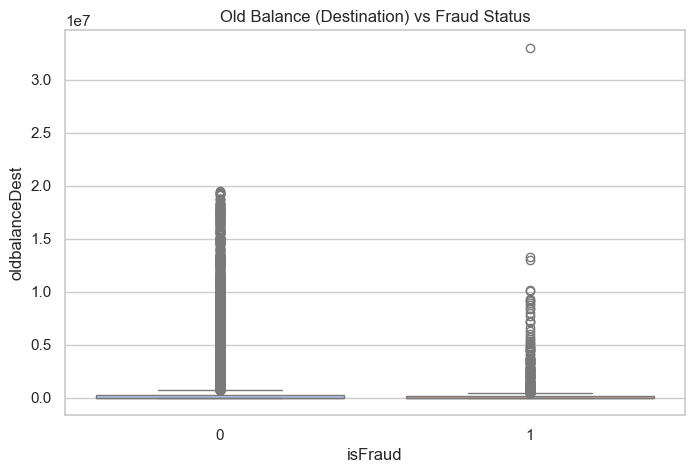

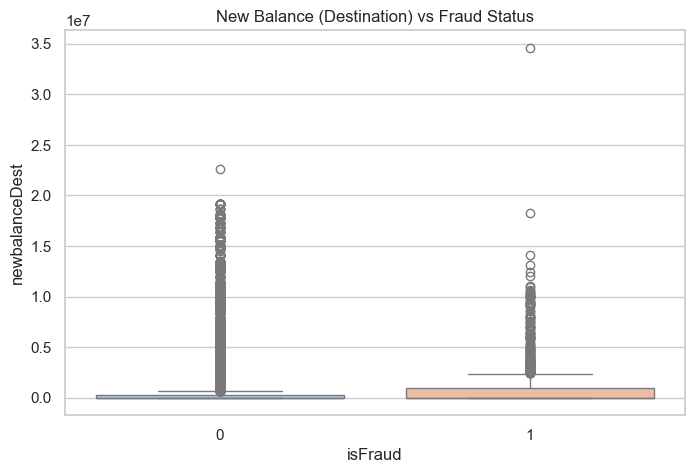

In [15]:
plt.figure()
sns.boxplot(x='isFraud', y='oldbalanceOrg', data=df, palette="coolwarm")
plt.title("Old Balance (Origin) vs Fraud Status")
plt.show()

plt.figure()
sns.boxplot(x='isFraud', y='newbalanceOrig', data=df, palette="coolwarm")
plt.title("New Balance (Origin) vs Fraud Status")
plt.show()

plt.figure()
sns.boxplot(x='isFraud', y='oldbalanceDest', data=df, palette="coolwarm")
plt.title("Old Balance (Destination) vs Fraud Status")
plt.show()

plt.figure()
sns.boxplot(x='isFraud', y='newbalanceDest', data=df, palette="coolwarm")
plt.title("New Balance (Destination) vs Fraud Status")
plt.show()

### Check for potential data leakage

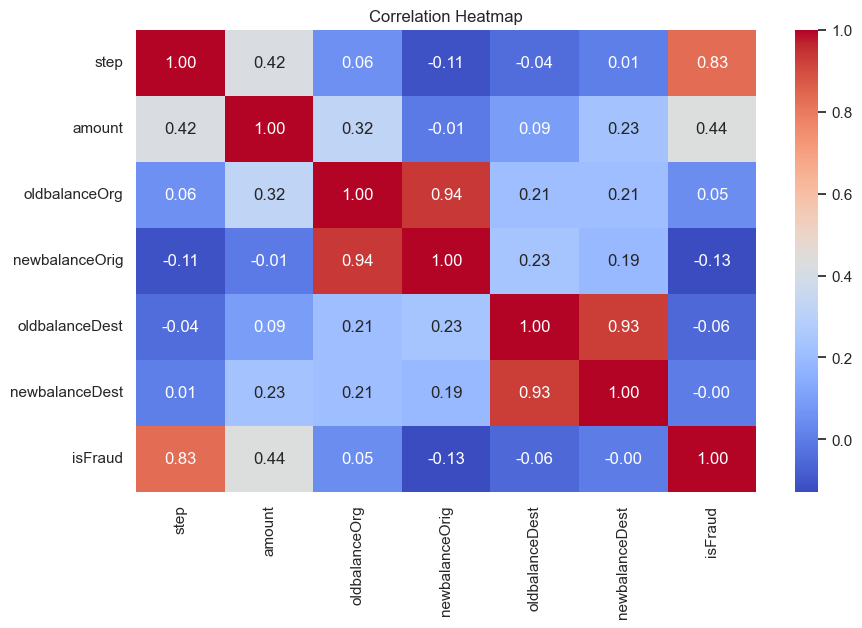

In [16]:
# Correlation matrix to see if any feature is strongly correlated with isFraud
plt.figure(figsize=(10,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [17]:
observations_eda = """
 Observations:
1. Fraud is highly concentrated in certain transaction types, with '{}' having the highest fraud rate (~{:.2f}%).
2. Fraud rates tend to increase significantly for higher transaction amount buckets, especially above 100K.
3. Fraud cases over time are not evenly distributed — certain periods (steps) have clear spikes.
4. Account balance patterns differ for fraud vs non-fraud transactions, suggesting these features may be predictive.
5. Some variables show strong correlation with isFraud, indicating possible high predictive power but also potential data leakage risks.
""".format(fraud_dist_type.idxmax(), fraud_dist_type.max())

print(observations_eda)


 Observations:
1. Fraud is highly concentrated in certain transaction types, with 'TRANSFER' having the highest fraud rate (~38.52%).
2. Fraud rates tend to increase significantly for higher transaction amount buckets, especially above 100K.
3. Fraud cases over time are not evenly distributed — certain periods (steps) have clear spikes.
4. Account balance patterns differ for fraud vs non-fraud transactions, suggesting these features may be predictive.
5. Some variables show strong correlation with isFraud, indicating possible high predictive power but also potential data leakage risks.



** Deep EDA**
   - Calculated fraud rates within each transaction type.
   - Created amount buckets and analyzed fraud frequency per bucket.
   - Examined fraud time trends by type.
   - Explored account balances before/after transactions.
   - Checked correlations for potential data leakage.

# Preprocessing

In [18]:
# Drop unneeded identifiers
df_processed = df.drop(['nameOrig', 'nameDest', 'amount_bucket'], axis=1, errors='ignore')
print("Dropped identifier columns. Shape now:", df_processed.shape)

# encode 'type'
df_processed = pd.get_dummies(df_processed, columns=['type'], drop_first=True)
print("\nAfter one-hot encoding, shape:", df_processed.shape)


Dropped identifier columns. Shape now: (11142, 8)

After one-hot encoding, shape: (11142, 11)


In [19]:
# Separate features (X) and target (y)
X = df_processed.drop('isFraud', axis=1)
y = df_processed['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Scaling numeric features (optional but recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaling done. Feature matrix is now ready for modeling.")


Scaling done. Feature matrix is now ready for modeling.


In [21]:
# Class imbalance check
fraud_train_counts = y_train.value_counts()
print("\nClass distribution in training set:\n", fraud_train_counts)
print("Imbalance ratio: {:.2f}% fraud".format(fraud_train_counts[1] / len(y_train) * 100))



Class distribution in training set:
 isFraud
0    8001
1     912
Name: count, dtype: int64
Imbalance ratio: 10.23% fraud



3. ** Preprocessing**
   - Dropped identifier columns (`nameOrig`, `nameDest`).
   - One-hot encoded transaction type (`type`).
   - Stratified train-test split to keep fraud ratio balanced.
   - Scaled numeric features for modeling.

# Feature Engineering
- Creates all required feature engineering columns (balance errors, merchant flag, high-value flag, time features).
- Drops IDs to avoid leakage.
- One-hot encodes transaction types.
- Splits data into train/test (with stratification).
- Scales features for models that need it.
- Saves everything:

In [22]:
df_features = df.copy()
df_features.head()



,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_bucket
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,<1K
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,<1K
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,1K–10K
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,1K–10K
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,10K–50K


In [23]:
# Balance difference features
df_features['error_balance_orig'] = df_features['oldbalanceOrg'] - df_features['amount'] - df_features['newbalanceOrig']
df_features['error_balance_dest'] = df_features['newbalanceDest'] - df_features['oldbalanceDest'] - df_features['amount']

In [24]:
# Merchant flag (nameDest starting with 'M')
df_features['isMerchant'] = df_features['nameDest'].str.startswith('M').astype(int)

# High-value transaction flag (consistent with app.py: > 200000)
df_features['high_value'] = (df_features['amount'] > 200000).astype(int)

# Time-based features from 'step'
df_features['day'] = df_features['step'] // 24
df_features['hour'] = df_features['step'] % 24


In [25]:
# Drop raw IDs
df_features = df_features.drop(['nameOrig', 'nameDest', 'amount_bucket'], axis=1, errors='ignore')


In [26]:
# One-hot encode 'type'
df_features = pd.get_dummies(df_features, columns=['type'], drop_first=True)


In [27]:
# Separate features and target
X = df_features.drop('isFraud', axis=1)
y = df_features['isFraud']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [28]:
# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [29]:
# Save processed data & objects
df_features.to_csv("processed_fraud_data.csv", index=False)  # For Power BI / later analysis
joblib.dump(scaler, "scaler.pkl")  # Save scaler for deployment
joblib.dump((X_train, X_test, y_train, y_test), "train_test_split.pkl")  # Unscaled split
joblib.dump((X_train_scaled, X_test_scaled, y_train, y_test), "scaled_train_test_split.pkl")  # Scaled split

print("Feature engineering complete & consistent with app.py")
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

Feature engineering complete & consistent with app.py
Train shape: (8913, 16) | Test shape: (2229, 16)
